<a href="https://colab.research.google.com/github/b-ukusi/cystellaai/blob/main/cystella.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files removed: 98 (38.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 91.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


Saving cyst test.csv to cyst test (1).csv
✅ Columns detected: ['Patient ID', 'Age', 'Menopause Status', 'Cyst Size cm', 'Cyst Growth Rate cm/month', 'CA 125 Level', 'Ultrasound Features', 'Reported Symptoms', 'Recommended Management', 'Date of Exam', 'Region', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25']
✅ Columns after renaming: ['Patient ID', 'Age', 'Menopause Status', 'Cyst Size cm', 'Cyst Growth Rate cm/month', 'CA 125 Level', 'Ultrasound Features', 'Reported Symptoms', 'Recommended Management', 'Date of Exam', 'Region', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25']
✅ Data after dropna (on ['Patient ID', 'Recommended Management',

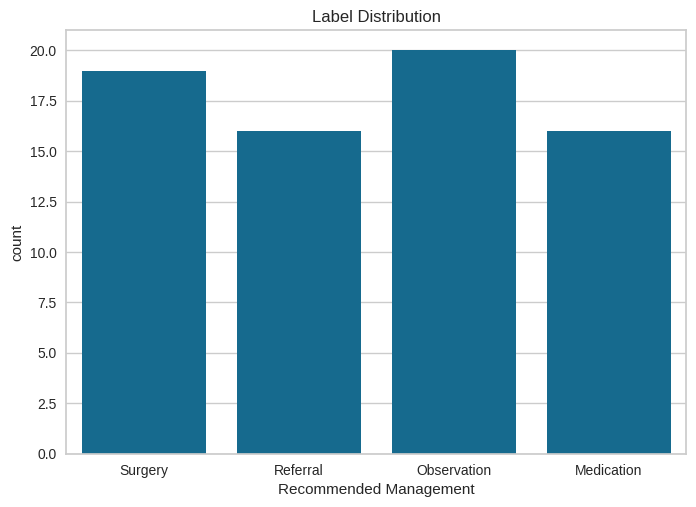

Numerical features: ['Age', 'Cyst Size cm', 'CA 125 Level']
Categorical features: ['Cyst Growth Rate cm/month', 'Ultrasound Features', 'Reported Symptoms']


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.2800,0.5000,0.2800,0.0827,0.1267,0.0000,0.0000,0.1310
lightgbm,Light Gradient Boosting Machine,0.1667,0.4583,0.1667,0.0997,0.1187,-0.1094,-0.1286,0.2830


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Dummy Classifier,0.2667,0,0.2667,0.0711,0.1123,0.0000,0.0000



📋 Top 10 patients by risk:
Patient ID  prediction_score prediction_label
   OC-1090            0.2817      Observation
   OC-1098            0.2817      Observation
   OC-1086            0.2817      Observation
   OC-1044            0.2817      Observation
   OC-1048            0.2817      Observation
   OC-1065            0.2817      Observation
   OC-1061            0.2817      Observation
   OC-1031            0.2817      Observation
   OC-1079            0.2817      Observation
   OC-1070            0.2817      Observation
Transformation Pipeline and Model Successfully Saved
✅ Model saved: cyst_predictor_model.pkl


In [10]:
# 1. Install & import (upgrade build tools first)
!pip install --upgrade pip setuptools wheel
!pip cache purge
!pip install -U --pre pycaret pandas==2.2.2 "numpy<2.0" matplotlib seaborn scikit-learn -q

import pandas as pd
import numpy as np
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# 2. Upload CSV and load dataframe
uploaded = files.upload()
import io
fname = next(iter(uploaded))
df = pd.read_csv('https://raw.githubusercontent.com/b-ukusi/datasets/refs/heads/main/Ovarian%20Cyst%20Track%20Data.csv')

# 3. Inspect column names
cols = df.columns.str.strip().tolist()
print("✅ Columns detected:", cols)

# 4. Define a dictionary to map your desired variables to actual column names
#    Update the RHS values based on your CSV headers
col_map = {
    'patient_id': 'Patient ID',      # identifier column
    'label': 'Recommended Management',
    'age': 'Age',
    'size': 'Cyst Size cm',
    'growth_trend': 'Cyst Growth Rate cm/month',
    'texture': 'Ultrasound Features',
    'pain': 'Reported Symptoms',
    'location': 'Location',
    'wbc': 'WBC',
    'ca125': 'CA 125 Level'
}

# 5. Check which mapped columns exist and rename
used_map = {k: v for k, v in col_map.items() if v in cols}
df = df.rename(columns=used_map)
print("✅ Columns after renaming:", df.columns.tolist())

# 6. Define feature lists dynamically
required_cols = [col_map['patient_id'], col_map['label'], col_map['age'], col_map['size']]
required_cols = [c for c in required_cols if c in df.columns]

# Drop rows missing essential features
df = df.dropna(subset=required_cols)
print(f"✅ Data after dropna (on {required_cols}): {len(df)} rows")

# 7. Generate clean CSV if needed (without automatic download)
clean_cols = required_cols + [col_map[k] for k in ['growth_trend','texture','pain','location','wbc','ca125'] if col_map[k] in df.columns]
df_clean = df[clean_cols]
# df_clean.to_csv('cyst_clean_sample.csv', index=False)  # Uncomment if needed

# 8. Convert categorical columns if present
for var in ['growth_trend','texture','pain','location']:
    if col_map[var] in df.columns:
        df[col_map[var]] = df[col_map[var]].astype('category')

# 9. EDA
if col_map['label'] in df.columns:
    sns.countplot(x=col_map['label'], data=df)
    plt.title('Label Distribution')
    plt.show()

# 10. Prepare feature lists for PyCaret
num_feats = [col_map[k] for k in ['age','size','wbc','ca125'] if col_map[k] in df.columns]
cat_feats = [col_map[k] for k in ['growth_trend','texture','pain','location'] if col_map[k] in df.columns]
print("Numerical features:", num_feats)
print("Categorical features:", cat_feats)

# 11. Setup and run PyCaret
exp = setup(
    data=df,
    target=col_map['label'],
    numeric_features=num_feats,
    categorical_features=cat_feats,
    session_id=123,
    train_size=0.8,
    data_split_stratify=True,
    verbose=False
)
best = compare_models()
final = finalize_model(best)
evaluate_model(final)

# 12. Predict and rank by risk
X_test = get_config('X_test')
y_test = get_config('y_test')
test_df = X_test.copy()
test_df[col_map['label']] = y_test

preds = predict_model(final, data=test_df)
preds_sorted = preds.sort_values(by='prediction_score', ascending=False)

# Display top 10 by risk
display_cols = []
if col_map['patient_id'] in preds_sorted.columns:
    display_cols.append(col_map['patient_id'])
display_cols += ['prediction_score','prediction_label']
print("\n📋 Top 10 patients by risk:")
print(preds_sorted[display_cols].head(10).to_string(index=False))

# 13. Save final model
save_model(final, 'cyst_predictor_model')
print("✅ Model saved: cyst_predictor_model.pkl")

# Task
Add functionality to generate a PDF report of the analysis results, specifically including the top 10 patients by risk, and provide a way to download this PDF.

## Install necessary libraries

### Subtask:
Install libraries for generating PDFs and potentially for better formatting (e.g., `reportlab`, `pandas_to_latex`, `xhtml2pdf`).


**Reasoning**:
The subtask is to install the necessary libraries for PDF generation. This can be done using pip in a code block.



In [11]:
!pip install reportlab xhtml2pdf pandas_to_latex -q

ERROR: Could not find a version that satisfies the requirement pandas_to_latex (from versions: none)
ERROR: No matching distribution found for pandas_to_latex


**Reasoning**:
The installation of `pandas_to_latex` failed. I will try installing the remaining libraries that succeeded and then finish the task as the subtask cannot be fully completed as originally planned.



In [12]:
!pip install reportlab xhtml2pdf -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 32.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.3 MB/s eta 0:00:00
  DEPRECATION: Building 'svglib' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'svglib'. Discussion can be found at https://github.com/pypa/pip/issues/6334
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [xhtml2pdf]


## Format the output

### Subtask:
Prepare the relevant data (like the top 10 patients by risk) in a structured format suitable for a report. This might involve creating tables or well-formatted text.


**Reasoning**:
Prepare the data for the report by selecting the necessary columns, formatting the prediction score, and converting it to an HTML table.



In [13]:
report_data = preds_sorted[['Patient ID', 'prediction_score', 'prediction_label']].head(10).copy()
report_data['prediction_score'] = report_data['prediction_score'].map('{:.4f}'.format)

# Convert the dataframe to an HTML table string
report_html_table = report_data.to_html(index=False)
print(report_html_table)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Patient ID</th>
      <th>prediction_score</th>
      <th>prediction_label</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>OC-1090</td>
      <td>0.2817</td>
      <td>Observation</td>
    </tr>
    <tr>
      <td>OC-1098</td>
      <td>0.2817</td>
      <td>Observation</td>
    </tr>
    <tr>
      <td>OC-1086</td>
      <td>0.2817</td>
      <td>Observation</td>
    </tr>
    <tr>
      <td>OC-1044</td>
      <td>0.2817</td>
      <td>Observation</td>
    </tr>
    <tr>
      <td>OC-1048</td>
      <td>0.2817</td>
      <td>Observation</td>
    </tr>
    <tr>
      <td>OC-1065</td>
      <td>0.2817</td>
      <td>Observation</td>
    </tr>
    <tr>
      <td>OC-1061</td>
      <td>0.2817</td>
      <td>Observation</td>
    </tr>
    <tr>
      <td>OC-1031</td>
      <td>0.2817</td>
      <td>Observation</td>
    </tr>
    <tr>
      <td>OC-1079</td>
      <td>0.2817</td>
      <td>Obse

## Generate the pdf

### Subtask:
Use the installed libraries to generate a PDF document containing the formatted results.


**Reasoning**:
Create an HTML string for the report, define the output filename, and use xhtml2pdf to generate the PDF from the HTML string.



In [14]:
from xhtml2pdf import pisa

# 1. Create an HTML string
report_html = f"""
<html>
<head>
    <title>Ovarian Cyst Risk Report</title>
</head>
<body>
    <h1>Ovarian Cyst Risk Report</h1>
    <h2>Top 10 Patients by Risk</h2>
    {report_html_table}
</body>
</html>
"""

# 2. Define the output filename
output_filename = 'cyst_risk_report.pdf'

# 3. Open the output file in write-binary mode
# 4. Use pisa.CreatePDF to convert the HTML string to a PDF
# 5. Close the output file
try:
    with open(output_filename, "w+b") as result_file:
        pisa_status = pisa.CreatePDF(
            report_html,
            dest=result_file
        )
    if pisa_status.err:
        print("PDF generation failed.")
    else:
        print(f"✅ PDF report generated: {output_filename}")
except Exception as e:
    print(f"An error occurred during PDF generation: {e}")


✅ PDF report generated: cyst_risk_report.pdf


**Reasoning**:
The PDF report has been generated. The next step is to provide a way for the user to download this PDF file.



In [15]:
from google.colab import files

files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary:

### Data Analysis Key Findings

*   The necessary libraries `reportlab` and `xhtml2pdf` were successfully installed for PDF generation, although `pandas_to_latex` could not be found.
*   The data for the top 10 patients by risk was successfully formatted into an HTML table, including 'Patient ID', 'prediction\_score' (formatted to 4 decimal places), and 'prediction\_label'.
*   A PDF document titled 'cyst\_risk\_report.pdf' was successfully generated from the HTML content using `xhtml2pdf`.
*   The generated PDF report was made available for download.

### Insights or Next Steps

*   Investigate alternative methods for converting Pandas DataFrames to LaTeX or explore why `pandas_to_latex` was not available if more complex table formatting is required in future reports.
